# Tutorial 03: road compliance checking

The collision checker library provides a convenient way to construct the road boundary for a scenario and check if the vehicle is within the road.


## 1. Load the scenario
We import necessary modules and load the example scenario.

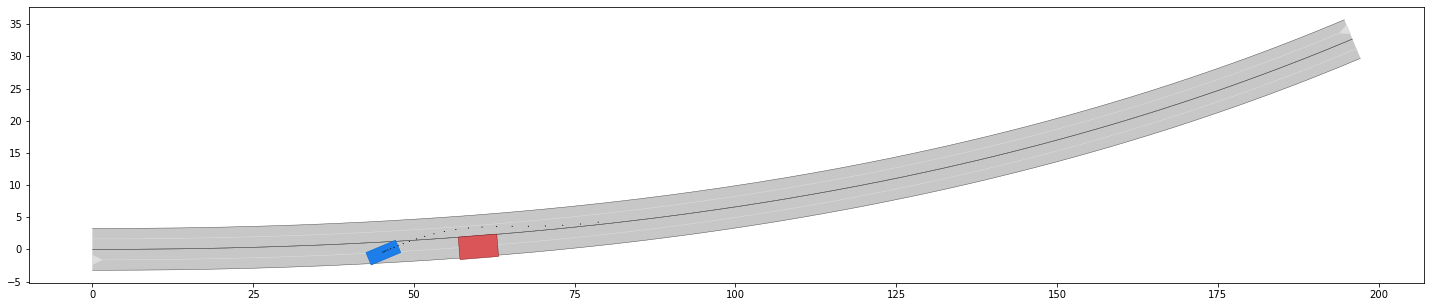

In [33]:
%matplotlib inline
import numpy as np
from time import time
import matplotlib.pyplot as plt

# commonroad
from commonroad.common.file_reader import CommonRoadFileReader

#commonroad_dc
from commonroad_dc.collision.visualization.draw_dispatch import draw_object
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker
import commonroad_dc.pycrcc as pycrcc



def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set

#open the example scenario
scenario, planning_problem_set = open_scenario("Tut_compliance.xml")


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()


## 2. Build the road boundary

The drivability checker library provides several methods to check road compliance. In particular, methods for the following
two general approaches are implemented:
* **Road boundary collision check (see Section 2.1.)**: checks whether the ego vehicle trajectory collides with the boundary, which is approximated using simple shapes.
* **Occupancy inclusion (see Section 2.2.)**: checks whether the ego vehicle occupancy is included within the drivable road network for the entire trajectory.

Both approaches to check road compliance are complementary to each other. Our toolbox provides different methods for each approach,
which might differ in their performance. We demonstrate the methods in the follwing two sections.


### 2.1. Road Boundary Collision Check
The road boundary can be approximated using either triangulation (Section 2.1.1. - 2.1.3.) or oriented rectangles (Section 2.1.4.).

### 2.1.1. Delaunay Triangulation

Computation time: 0.6363141536712646
Number of boundary elements: 1161


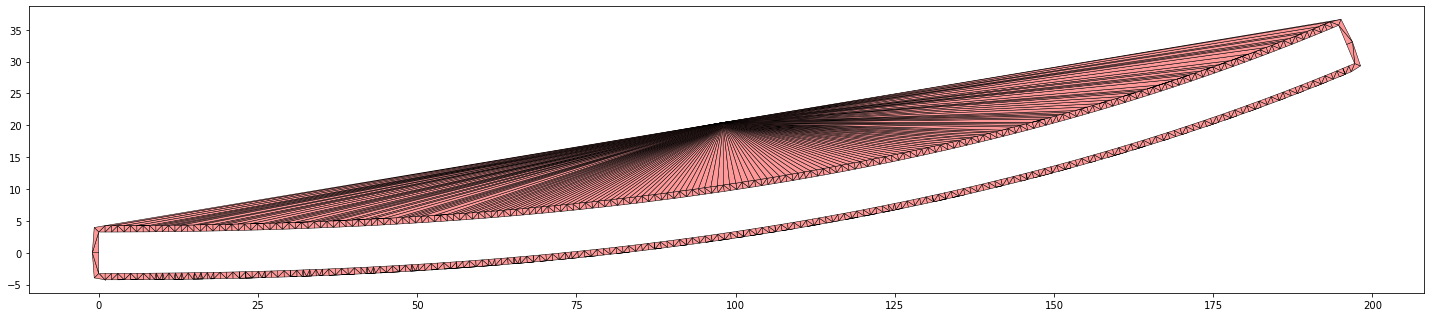

In [34]:
time1=time()
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()
print("Number of boundary elements: %s" % road_boundary_sg_triangles.size())


### 2.1.2. Axis-Aligned Triangles (Horizontal)

Computation time: 0.31598663330078125
Number of boundary elements: 920


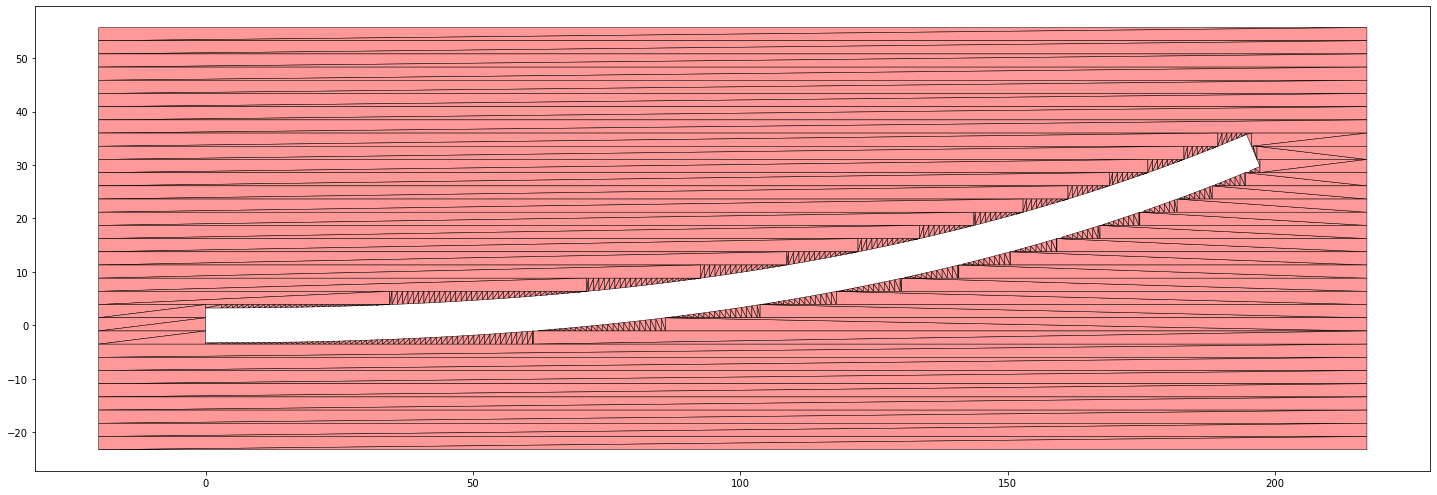

In [35]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=1)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_aligned_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())


### 2.1.3. Axis-Aligned Triangles (Vertical)

Computation time: 0.44144201278686523
Number of boundary elements: 960


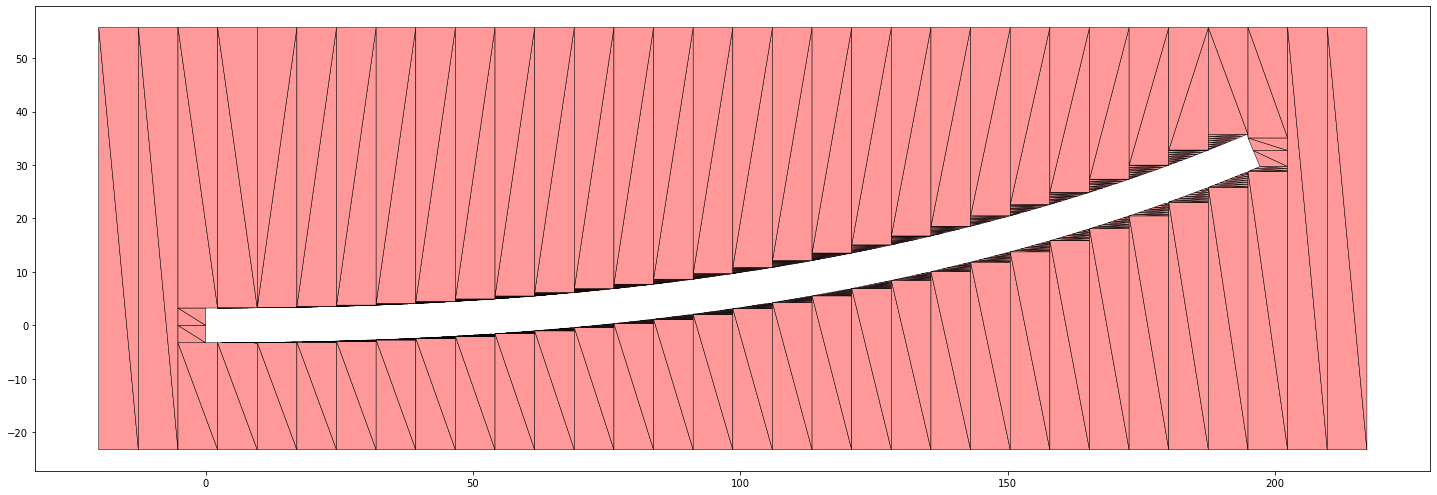

In [36]:
time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=2)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_aligned_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print("Number of boundary elements: %s" % road_boundary_sg_aligned_triangles.size())


### 2.1.4. Oriented Rectangles

Computation time: 0.017795085906982422
Number of boundary elements: 400


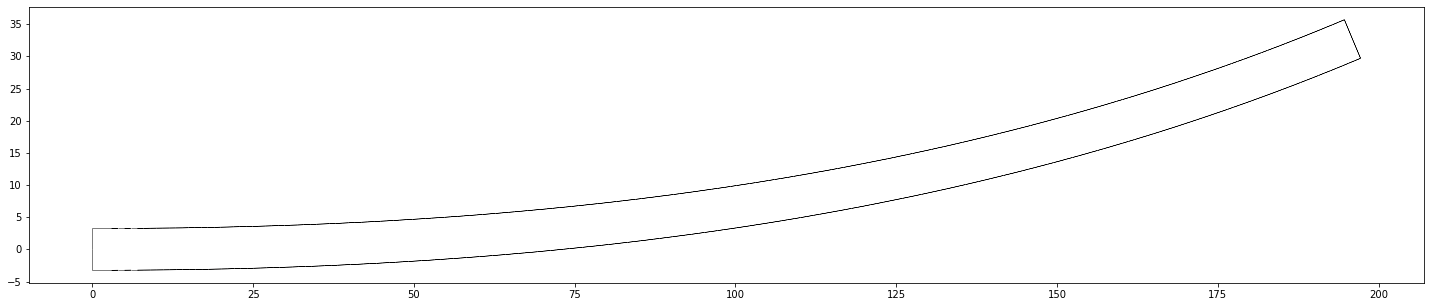

In [37]:
time1=time()
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_rectangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print("Number of boundary elements: %s" % road_boundary_sg_rectangles.size())


## 2.2. Occupancy Inclusion
The occupancy inclusion approach represents the drivable road network by a set of polygons. Three different methods are
available to construct the polygons.

### 2.2.1. Lane Polygons

Computation time: 0.005429983139038086


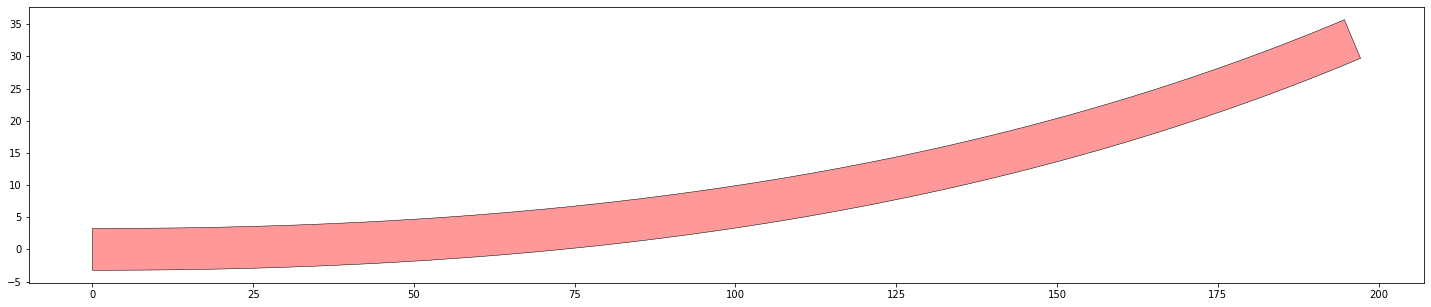

In [38]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()


### 2.2.2. Polygons with Holes (Grid)

Computation time: 0.01564192771911621


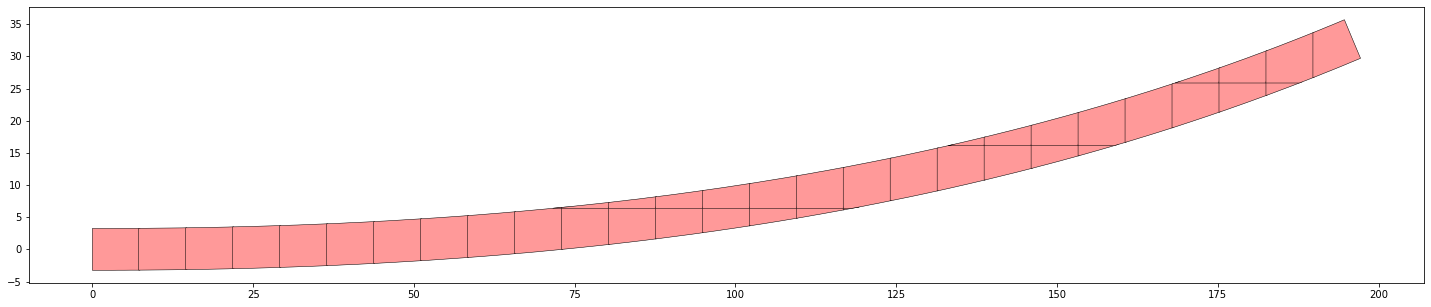

In [39]:
# length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

time1=time()
road_boundary_sg_polygons_grid=boundary.create_road_polygons(scenario, method='whole_polygon_tiled', max_cell_width=car_half_length*3, max_cell_height=car_half_length*5,triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons_grid)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

### 2.2.3. Polygons with Holes

Computation time: 0.0006413459777832031


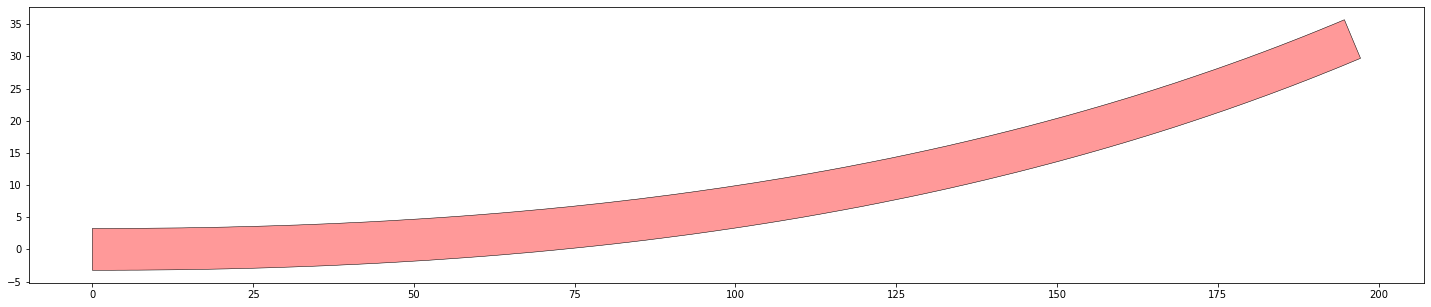

In [40]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

## 3. Check if the trajectory is within the road

After constructing a road boundary, we can check whether a given trajectory is road-compliant.

### 3.1. Select part of the trajectory for compliance checks

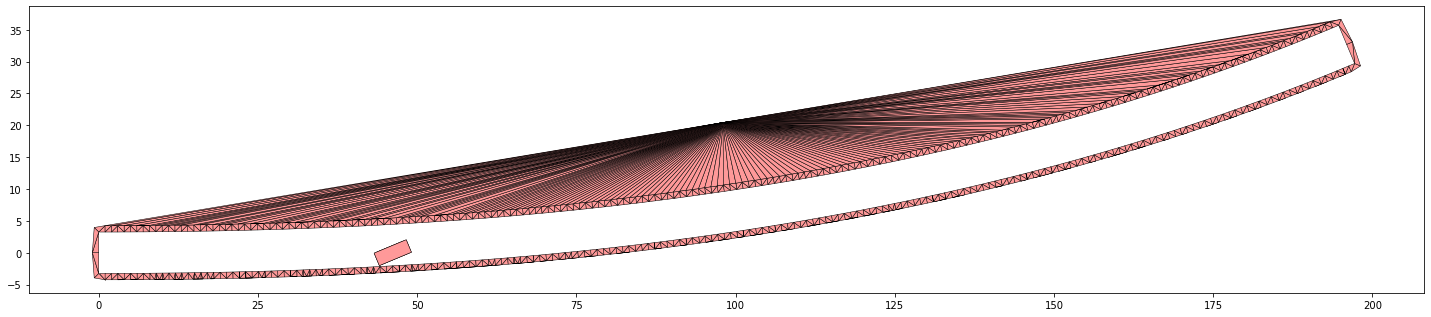

In [41]:
start_step=3

# half-length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# half-width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

#list with trajectory states that are checked for collisions with the road boudnary
traj_list=list()
state_list=scenario.dynamic_obstacles[0].prediction.trajectory.state_list

# add all trajectory steps from start_step onwards into traj_list
for el in state_list[start_step:]:

    new_el=list()
    new_el.append(el.position[0])
    new_el.append(el.position[1])
    new_el.append(el.orientation)
    traj_list.append(new_el)
    
#draw the ego-vehicle as an oriented rectangle at Step i of the traj_list
i=0
obb=pycrcc.RectOBB(car_half_length,car_half_width , traj_list[i][2],traj_list[i][0],traj_list[i][1])
obb_next=pycrcc.RectOBB(car_half_length,car_half_width , traj_list[i+1][2],traj_list[i+1][0],traj_list[i+1][1])
obb_merged=obb.merge(obb_next)

# draw the road boundary (here using triangulation)
plt.figure(figsize=(25, 25))
draw_object(road_boundary_sg_triangles)

draw_object(obb)
draw_object(obb_next)
draw_object(obb_merged)

plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()


We create a time-varying collision object for the ego vehicle.

In [42]:
def create_tvobstacle(traj_list,car_half_length,car_half_width):
    retObj=pycrcc.TimeVariantCollisionObject(0)
    for time_step in traj_list:
        retObj.append_obstacle(pycrcc.RectOBB(car_half_length, car_half_width, time_step[2],time_step[0],time_step[1]))
    return retObj    

co=create_tvobstacle(traj_list,car_half_length,car_half_width)

In [43]:
preprocessed_trajectories=list()
trajectories_first_object=list()
for el in range(1000):
    trajectories_first_object.append(traj_list[start_step:start_step])
cur_time_1=time()
for el in range(1000):
    traj, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
    if(err):
        raise Exception("trajectory preprocessing error")
    preprocessed_trajectories.append(traj)

cur_time_2 = time()

print('trajectory preprocessing time (OBB sum hull) for 1000 trajectories: ' + str(cur_time_2-cur_time_1))

trajectory preprocessing time (OBB sum hull) for 1000 trajectories: 0.009986400604248047


We can then check whether the trajectories are compliant to the road network using the approaches described above:

### Approach 1: Road boundary collision checks

#### Triangulation

In [44]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(trajectories_first_object):
        if trajectory_enclosure_polygons_static(road_boundary_sg_polygons,car_half_length, car_half_width, el)==-1:    
            candidate_trajectories.append(preprocessed_trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_aligned_triangles, method='grid', num_cells=32, auto_orientation=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.01017453670501709 sec.


#### Oriented Rectangles

In [45]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(trajectories_first_object):
        if trajectory_enclosure_polygons_static(road_boundary_sg_polygons,car_half_length, car_half_width, el)==-1:
            candidate_trajectories.append(preprocessed_trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)


cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.006472182273864746 sec.


### Approach 2: Occupancy Inclusion

#### Polygons with holes (grid)

In [46]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(preprocessed_trajectories):
        candidate_trajectories.append(el)
    ret=trajectory_queries.trajectories_enclosure_polygons_static(candidate_trajectories, road_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)

cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.09104535579681397 sec.


## 4. Minkowski sum for road boundary

As demonstrated in *Tutorial 02: CommonRoad Interface*, our toolbox allows us to compute the minkowski sum with a circle
for any *commonroad-io* shape. The same can be done for the road boundary obstacle when using approach 1 for road compliance
checking. As shown below, we can inflate the road boundary obstacle which corresponds to specifying a safety distance
the vehicle should keep to the road boundary.


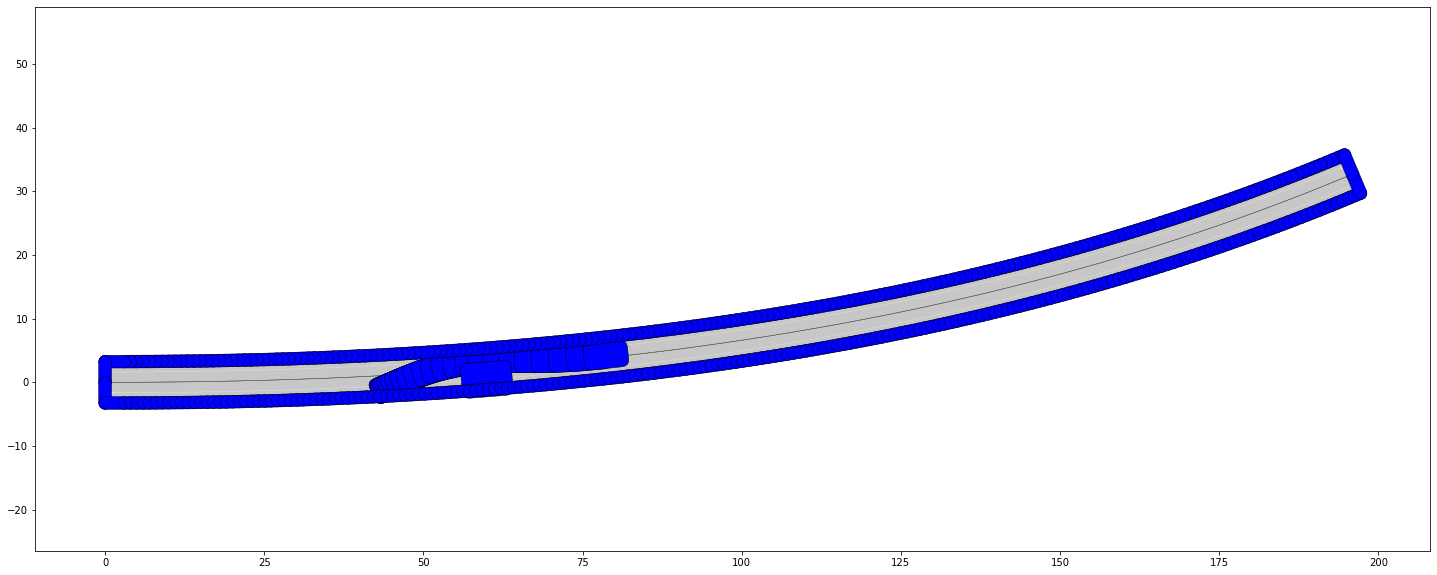

In [47]:
# create road boundary obstacle (here using oriented rectangles)
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles')

# add road boundary as static obstacle to scenario
scenario.add_objects(road_boundary_obstacle)

# create collision checker for scenario
cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True,
                                                'minkowski_sum_circle_radius': 1.0,
                                                'resolution': 4})

# visualize scenario and collision objects
plt.figure(figsize=(25, 10))
draw_object(scenario.lanelet_network)
draw_object(cc, draw_params={'collision': {'facecolor': 'blue'}})
plt.autoscale()
plt.axis('equal')
plt.show()